# Основы машинного обучения (ИАД)
## НИУ ВШЭ, 2021-2022 учебный год

### Домашнее задание №8

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, mean_squared_error

# Бустинг

## Градиентный бустинг своими руками (3 + 2* баллов)

Реализуйте алгоритм градиентного бустинга для регрессии. Напомним **основные формулы**.

Обозначим текущую композицию на $N-1$ шаге за $a_{N - 1}(x_i)$. Следующий базовый алгоритм $b_N(x_i)$ обучается на ответах $-\frac{\partial L(y_i, z)}{\partial z}\Bigl|_{z = a_{N - 1}(x_i)}$, где $L(y_i, z)$ — значение функции потерь на объекте при правильном ответе $y_i$ и предсказании $z$. Композиция на следующем шаге получается следующим образом:

$$
a_N(x_i) = a_{N-1}(x_i) + \nu\gamma_Nb_N(x_i)
$$

Здесь $\nu$ — гиперпараметр learning rate, $\gamma_N$ — оптимальный вес, настраиваемый на каждом шаге алгоритма, который можно найти по следующей формуле (обратите внимание на отсутствие $\nu$):

$$
\gamma_N = \mathrm{arg}\min_\gamma \frac{1}{\ell}\sum\limits_{i=1}^{\ell}L\left(y_i, a_{N - 1}(x_i) + \gamma b_N(x_i)\right)
$$

Можете принять $\gamma_N = 1$ для каждого $N$.

> Реализуйте нахождение оптимального $\gamma_N$ на каждом шаге, чтобы получить ещё 1 балл.


В качестве функции потерь возьмите **MSE**.

*Примечание. Вы можете использовать `DecisionTree` из `sklearn` и методы оптимизации из различных библиотек.*

In [2]:
# это может помочь вам для поиска оптимальных gamma
from scipy.optimize import minimize

In [7]:
from sklearn.base import BaseEstimator


class GradientBoosting(BaseEstimator):
    def __init__(self, n_estimators=30, max_depth=10, learning_rate=0.1):
        """
        PARAMETERS:
        n_estimators - number of trees in the ensemble
        max_depth - maximum depth of a tree
        learning_rate - coefficient by which new algorithm result is multiplied
        """

        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.__trees = None
        self.__current_pred = None

    def _best_gamma(self, y, new_tree_pred):
        def gamma_fun(gamma):
            y_pred = self.__current_pred + gamma * new_tree_pred
            return mean_squared_error(y, y_pred)

        minn = minimize(gamma_fun, x0=np.zeros((1,)))

        return minn.x

    def fit(self, x, y):
        """
        INPUT:
        x - np.array of shape (k, d)
        y - np.array of shape (k,)
        """
        # Здесь нам нужно проитерироваться по n_estimators и обучить
        # соответствующее количество деревьев с помощью _fit_predict_tree(),
        # правильно обновляя y_new
        # Деревья нужно где-то сохранить, чтобы затем использовать в predict()

        self.__trees = list()
        self.__current_pred = np.zeros(x.shape[0])
        y_new = y

        for i in range(self.n_estimators):
            self.__current_pred += self._fit_predict_tree(x, y_new)
            y_new = y - self.__current_pred

    def _fit_predict_tree(self, x, y):
        # Обучаем дерево и возвращаем его предикшн
        tree = DecisionTreeRegressor(max_depth=self.max_depth)
        tree.fit(x, y)
        self.__trees.append(tree)
        tree_predict = tree.predict(x)

        # gamma = self._best_gamma(y, tree_predict)
        gamma = 1

        return gamma * self.learning_rate * tree_predict

    def predict(self, x):
        """
        INPUT:
        x - np.array of shape (m, d)
        OUTPUT:
        y_pred - np.array of shape (m,)
        """
        # Используем сохранённые деревья для расчёта агрегированного предикшна

        if len(self.__trees) == 0:
            raise AttributeError('Boosting must be fitted first')

        y_pred = np.zeros(shape=(x.shape[0],))
        for tree in self.__trees:
            y_pred += tree.predict(x)

        return y_pred

Проверьте вашу реализацию на Boston dataset. 

> Подберите оптимальные гиперпараметры, чтобы победить RandomForestRegressor как в обычном случае, так и при нахождении оптимального шага **(не меняйте параметры сида)**. При необходимости воспользуйтесь GridSearch. За это вы получите ещё 1 балл.



In [8]:
boston = load_boston()
X = boston.data
y = boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)


c:\users\dm1tr\desktop\ida-ml\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing

In [9]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_features=4, n_estimators=640, random_state=19052019)
rf.fit(X_train, y_train)
mean_squared_error(y_test, rf.predict(X_test))

9.63198271791959

In [10]:
from sklearn.model_selection import GridSearchCV

np.random.seed(19052019)

parameters = {
    'n_estimators': range(50, 301, 50),
    'max_depth': range(4, 9, 2),
    'learning_rate': np.arange(0.75, 1.25, 0.1)
}

gs = GridSearchCV(
    estimator=GradientBoosting(),
    param_grid=parameters,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=3
)

gs.fit(X_train, y_train)


Fitting 5 folds for each of 90 candidates, totalling 450 fits
[CV 1/5] END learning_rate=0.75, max_depth=4, n_estimators=50;, score=-83.554 total time=   0.0s
[CV 2/5] END learning_rate=0.75, max_depth=4, n_estimators=50;, score=-84.417 total time=   0.0s
[CV 3/5] END learning_rate=0.75, max_depth=4, n_estimators=50;, score=-76.512 total time=   0.0s
[CV 4/5] END learning_rate=0.75, max_depth=4, n_estimators=50;, score=-90.487 total time=   0.0s
[CV 5/5] END learning_rate=0.75, max_depth=4, n_estimators=50;, score=-75.255 total time=   0.0s
[CV 1/5] END learning_rate=0.75, max_depth=4, n_estimators=100;, score=-86.270 total time=   0.0s
[CV 2/5] END learning_rate=0.75, max_depth=4, n_estimators=100;, score=-79.687 total time=   0.0s
[CV 3/5] END learning_rate=0.75, max_depth=4, n_estimators=100;, score=-74.247 total time=   0.0s
[CV 4/5] END learning_rate=0.75, max_depth=4, n_estimators=100;, score=-89.598 total time=   0.0s
[CV 5/5] END learning_rate=0.75, max_depth=4, n_estimators=10

GridSearchCV(cv=5, estimator=GradientBoosting(),
             param_grid={'learning_rate': array([0.75, 0.85, 0.95, 1.05, 1.15]),
                         'max_depth': range(4, 9, 2),
                         'n_estimators': range(50, 301, 50)},
             scoring='neg_mean_squared_error', verbose=3)

In [11]:
print(gs.best_params_)
print(gs.best_score_)

{'learning_rate': 1.0499999999999998, 'max_depth': 6, 'n_estimators': 150}
-16.40084163092014


In [12]:
np.random.seed(19052019)

boosting = GradientBoosting(n_estimators=150, max_depth=6, learning_rate=1.05)

boosting.fit(X_train, y_train)
y_pred = boosting.predict(X_test)

print('MSE:', mean_squared_error(y_test, y_pred))

# Кажется победить лес нереально (ну или почти).
# Перебором параметров на тесте (нечестно) я в лучшем случае получал 12, что все равно хуже.
# Никто же не говорил, что бустинг будет всегда лучше леса =)

MSE: 18.575937503848145


In [13]:
np.random.seed(19052019)

boosting = GradientBoosting(n_estimators=150, max_depth=6, learning_rate=1)

boosting.fit(X_train, y_train)
y_pred = boosting.predict(X_test)

print('MSE:', mean_squared_error(y_test, y_pred))

MSE: 14.796310437078768


In [14]:
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor(n_estimators=100, max_depth=10, learning_rate=0.65)

gb.fit(X_train, y_train)
print(mean_squared_error(y_test, gb.predict(X_test)))

# Этот товарищ тоже не победил (параметры перебрал руками, это было лучшее).

11.128085510140187


Для удобства проверяющего укажите, пожалуйста, реализовали ли вы нахождение оптимального шага?

- Да, но с ним модель ведет себя менее адекватно. Есть вероятность, что нужно искать learning rate в других промежутках.
- Но я и так потратил миллион вермени на переборы GS.

## Прогнозируем задержки самолётов (2 балла)

Поработаем с задачей про задержки самолётов. На основании доступных данных о рейсе вам нужно определить, будет ли он задержан на 15 минут.
Воспользуйтесь любыми методами градиентного бустинга {`XGboost`, `catboost`, `LightGBM`} и `GridSearchCV` для достижения результата.

> Получите 1 балл за преодоление порога roc_auc_score 0.72 и ещё 1 балл за преодоление порога 0.74.



In [15]:
train = pd.read_csv(
    'https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering-data/flight_delays_train.csv')
test = pd.read_csv(
    'https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering-data/flight_delays_test.csv')

In [16]:
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [17]:
train.isna().sum()

Month                0
DayofMonth           0
DayOfWeek            0
DepTime              0
UniqueCarrier        0
Origin               0
Dest                 0
Distance             0
dep_delayed_15min    0
dtype: int64

In [18]:
test.isna().sum()

Month            0
DayofMonth       0
DayOfWeek        0
DepTime          0
UniqueCarrier    0
Origin           0
Dest             0
Distance         0
dtype: int64

In [19]:
train.dtypes

Month                object
DayofMonth           object
DayOfWeek            object
DepTime               int64
UniqueCarrier        object
Origin               object
Dest                 object
Distance              int64
dep_delayed_15min    object
dtype: object

In [20]:
numeric_features = train.select_dtypes(include=['int64', 'float64']).columns
numeric_features

Index(['DepTime', 'Distance'], dtype='object')

In [21]:
categorical_features = train.select_dtypes(include=['object']).drop(['dep_delayed_15min'], axis=1).columns
categorical_features

Index(['Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier', 'Origin', 'Dest'], dtype='object')

In [22]:
y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0})
X_train = train.drop('dep_delayed_15min', axis=1)
X_test = test

X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=43)
X_valid

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
12323,c-1,c-5,c-3,1747,XE,CLE,MSP,622
3341,c-10,c-8,c-6,1450,OH,BHM,CVG,396
87579,c-8,c-31,c-3,1734,US,CLT,MCO,468
46749,c-10,c-29,c-7,2145,YV,IAD,RDU,224
35134,c-8,c-12,c-6,2014,AA,DFW,MIA,1121
...,...,...,...,...,...,...,...,...
66311,c-7,c-24,c-7,1554,UA,SFO,SEA,679
12215,c-5,c-6,c-6,653,F9,DEN,DFW,641
68848,c-5,c-24,c-2,909,EV,ATL,BQK,238
90686,c-10,c-17,c-1,1430,WN,MDW,JAN,666


In [23]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
np.random.seed(43)

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [24]:
from xgboost.sklearn import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm.sklearn import LGBMClassifier

classifiers = [
    XGBClassifier(),
    CatBoostClassifier(verbose=False),
    LGBMClassifier()
]

In [25]:
np.random.seed(43)

for clf in classifiers:
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', clf)])
    pipe.fit(X_train_part, y_train_part)
    print(type(clf))
    print('AUC ROC:', roc_auc_score(y_valid, pipe.predict_proba(X_valid)[:, 1]))

# Пока что catboost лучше всех, поэтому будем подбирать гиперпараметры ему.

<class 'xgboost.sklearn.XGBClassifier'>
AUC ROC: 0.7476409445794682
<class 'catboost.core.CatBoostClassifier'>
AUC ROC: 0.7528710260172691
<class 'lightgbm.sklearn.LGBMClassifier'>
AUC ROC: 0.7471769220287862


In [27]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'classifier__n_estimators': range(300, 901, 100),
    'classifier__max_depth': range(4, 13, 2)
}

np.random.seed(432)

clf = CatBoostClassifier(logging_level='Silent')
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('classifier', clf)])

gs = GridSearchCV(
    estimator=pipe,
    param_grid=parameters,
    cv=10,
    scoring='roc_auc',
    verbose=3
)

gs.fit(X_train_part, y_train_part)
# - вечность

Fitting 10 folds for each of 35 candidates, totalling 350 fits
[CV 1/10] END classifier__max_depth=4, classifier__n_estimators=300;, score=0.734 total time=   3.6s
[CV 2/10] END classifier__max_depth=4, classifier__n_estimators=300;, score=0.747 total time=   3.4s
[CV 3/10] END classifier__max_depth=4, classifier__n_estimators=300;, score=0.727 total time=   2.6s
[CV 4/10] END classifier__max_depth=4, classifier__n_estimators=300;, score=0.736 total time=   2.4s
[CV 5/10] END classifier__max_depth=4, classifier__n_estimators=300;, score=0.731 total time=   2.3s
[CV 6/10] END classifier__max_depth=4, classifier__n_estimators=300;, score=0.734 total time=   2.4s
[CV 7/10] END classifier__max_depth=4, classifier__n_estimators=300;, score=0.729 total time=   2.0s
[CV 8/10] END classifier__max_depth=4, classifier__n_estimators=300;, score=0.736 total time=   1.8s
[CV 9/10] END classifier__max_depth=4, classifier__n_estimators=300;, score=0.739 total time=   1.8s
[CV 10/10] END classifier__m

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['DepTime', 'Distance'], dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         Index(['Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier', 'Origin', 'Dest'], dtype='object'))])),
                         

In [28]:
print(gs.best_params_)
print(gs.best_score_)

{'classifier__max_depth': 10, 'classifier__n_estimators': 900}
0.7442820241395303


In [29]:
clf = CatBoostClassifier(max_depth=10, n_estimators=900, logging_level='Silent')
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('classifier', clf)])
pipe.fit(X_train_part, y_train_part)
print('AUC ROC:', roc_auc_score(y_valid, pipe.predict_proba(X_valid)[:, 1]))

# Истинная победа.

AUC ROC: 0.7532386794587436


In [30]:
# Референс (без подготовки данных, очень такое себе, думаю нереально получить хороший результат)
from xgboost.sklearn import XGBClassifier

np.random.seed(423)

X_train = train[['Distance', 'DepTime']].values
y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_test = test[['Distance', 'DepTime']].values
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3)

xgb = XGBClassifier()
xgb.fit(X_train_part, y_train_part)
print('Sklearn AUC ROC:', roc_auc_score(y_valid, xgb.predict_proba(X_valid)[:, 1]))

cb = CatBoostClassifier(n_estimators=900, max_depth=10)
cb.fit(X_train_part, y_train_part, verbose=False)
print('Catboost AUC ROC:', roc_auc_score(y_valid, cb.predict_proba(X_valid)[:, 1]))

lgbm = LGBMClassifier()
lgbm.fit(X_train_part, y_train_part)
print('LightGBM AUC ROC:', roc_auc_score(y_valid, lgbm.predict_proba(X_valid)[:, 1]))

Sklearn AUC ROC: 0.7050210312597923
Catboost AUC ROC: 0.704577092299633
LightGBM AUC ROC: 0.7042077045004236


# Кластеризация

## DBSCAN своими руками (3 + 2* баллов)


```
DBSCAN: Density-based spatial clustering of applications with noise
```


Реализуйте класс dbscan.

Алгоритм имеет два основных гиперпараметра:
1. `eps` &mdash; радиус рассматриваемой окрестности
2. `min_samples` &mdash; число соседей в окрестности

Для выполнения кластеризации DBSCAN точки делятся на основные точки, достижимые по плотности точки и выпадающие следующим образом:

- Точка $p$ является основной точкой, если по меньшей мере `min_samples` точек находятся на расстоянии, не превосходящем 
`eps` от неё. Говорят, что эти точки достижимы прямо из $p$.

-  Точка $q$ прямо достижима из $p$, если точка $q$ находится на расстоянии, не большем `eps`, от точки $p$, и $p$ — основная точка.
Точка $q$ достижима из $p$, если имеется путь 
$p_1,…,p_n$ где $p_1=p$ и $p_n=q$ , а каждая точка $p_{i+1}$ достижима прямо из $p_i$ (все точки на пути должны быть основными, за исключением $q$).

Все точки, не достижимые из основных точек, считаются выбросами.

Теперь, если $p$ является основной точкой, то она формирует кластер вместе со всеми точками (основными или неосновными), достижимыми из этой точки. Каждый кластер содержит по меньшей мере одну основную точку. Неосновные точки могут быть частью кластера, но они формируют его «край», поскольку не могут быть использованы для достижения других точек.


In [31]:
# Это может помочь вам для поиска дистанции между точками
from scipy.spatial import distance

In [32]:
# Рекомендации -- это только рекомендации

class DBscan:
    def __init__(self, eps, min_samples):
        self.eps = eps
        self.min_samples = min_samples

        # Помечаем переданные точки, чтобы отличать уже кластеризованные
        # или являющиеся шумом от остальных
        self.labels = np.full(X.shape[0], 0)
        self.X = None
        self.__total_clusters = 0

    def fit_predict(self, X):
        self.__total_clusters = 0
        self.X = X
        # Реализуем цикл по точкам, игнорирущий уже кластеризованные

        for ind in range(len(self.X)):
            if self.labels[ind] == 0:
                # Если точка ещё не кластеризована, с помощью range_query() ищем её соседей
                neighbours = self.range_query(self.X[ind])

                if len(neighbours) < self.min_samples:
                    # Если соседей недостаточно, то помечаем её выделенным под шум лейблом
                    # (однако она ещё может попасть в какой-то иной кластер)

                    self.labels[ind] = -1
                else:
                    # Если же соседей достаточно, будем строить от неё кластер с помощью grow_cluster()

                    self.__total_clusters += 1
                    self.labels[ind] = self.__total_clusters
                    self._grow_cluster(ind, neighbours)

        return self.labels

    def _grow_cluster(self, root_ind, neighbours):
        # В этой функции мы полностью строим кластер относительно переданной точки
        # Т.е. реализуем цикл по структуре данных, изначально состоящей из уже
        # известных соседей (neighbours) и в процессе пополняющейся
        # "соседями соседей" с помощью range_query()

        while len(neighbours) > 0:
            next_neighbours = list()

            for neigh_ind in neighbours:
                current_neighbour = self.X[neigh_ind]
                current_label = self.labels[neigh_ind]

                if current_label == 0:
                    neighbour_neighbours = self.range_query(current_neighbour)
                    # Строго больше, чтобы не учитывать одну точку, гарантированно имеющуюся
                    # в range_query
                    if len(neighbour_neighbours) > self.min_samples:
                        next_neighbours.extend(neighbour_neighbours)
                if current_label == -1 or current_label == 0:
                    self.labels[neigh_ind] = self.__total_clusters
            neighbours = next_neighbours

    def range_query(self, x):
        """Возвращает индексы точек на расстоянии <= eps от x"""
        if self.X is None:
            raise AttributeError('DBscan must be fitted first')
        # Тут также есть точка(и), совпадающая(ие) с самой точкой х.
        return [i for i in range(len(self.X)) if distance.euclidean(self.X[i], x) <= self.eps]


Проверим себя на простом примере:

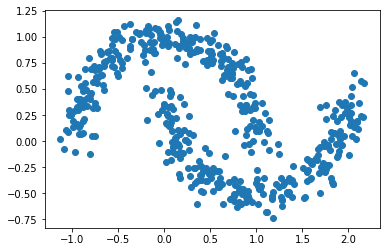

In [33]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import pandas as pd

np.random.seed(323)

X, _ = make_moons(n_samples=500, noise=0.1)
plt.scatter(X[:, 0], X[:, 1])
plt.show()

Кластеризуйте это с помощью своей версии DBSCAN:

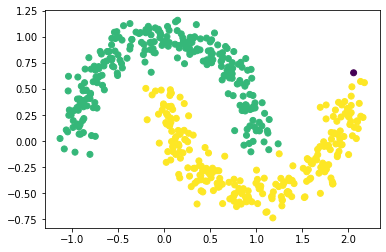

In [34]:
clusters = DBscan(eps=0.2, min_samples=10).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=clusters)
plt.show()

Референс:

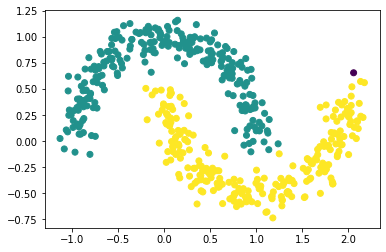

In [35]:
from sklearn.cluster import DBSCAN

clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c=clusters)
plt.show()


> Получите 1 балл за ещё один интересный пример кластеризации (в качестве референса используйте предоставленное изображение. Нужно несколько интересных соседствующих форм):



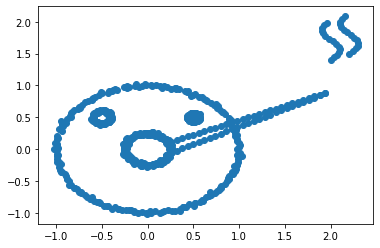

In [36]:
from sklearn.datasets import make_circles

np.random.seed(323)
generator = np.random.RandomState(123)

X_1, _ = make_circles(n_samples=400, noise=0.015, factor=0.25)
X_2, _ = make_circles(n_samples=100, noise=0.1, factor=0.9)
X_2 /= 15
X_2 += 0.5

X_3, _ = make_circles(n_samples=100, noise=0.1, factor=0.99)
X_3 /= 10
X_3[:, 0] -= 0.5
X_3[:, 1] += 0.5

smoke_x = np.linspace(0, 2 * np.pi, 15, endpoint=False)
smoke_y = np.sin(smoke_x) / 10

full_smoke = np.vstack(
    [smoke_y + 2, smoke_x / 10 + 1.4]
).T

full_smoke_2 = np.vstack(
    [smoke_y + 2.2, smoke_x / 10 + 1.5]
).T

cig_x = np.linspace(0.2, 2, 30, endpoint=False)
cig_y = cig_x / 2.2

full_cig = np.vstack(
    [cig_x, cig_y]
).T

full_cig_2 = np.vstack(
    [cig_x, cig_y * 1.22 - 0.2]
).T

X = np.vstack([X_1, X_2, X_3, full_smoke, full_cig, full_smoke_2, full_cig_2])

plt.scatter(X[:, 0], X[:, 1])
plt.show()

In [37]:
import itertools

epss = np.arange(0.01, 0.33, 0.03)
minns = range(2, 30, 2)

np.random.seed(342)

# for e, m in itertools.product(epss, minns):
#     print(e, m)
#     clusters = DBscan(eps=e, min_samples=m).fit_predict(X)
#     plt.scatter(X[:, 0], X[:, 1], c=clusters)
#     plt.show()

# Такой перебор тоже не помог найти идеальную кластеризацию.
# Лучшие варианты ниже:

    Или хотя бы что-нибудь такое:

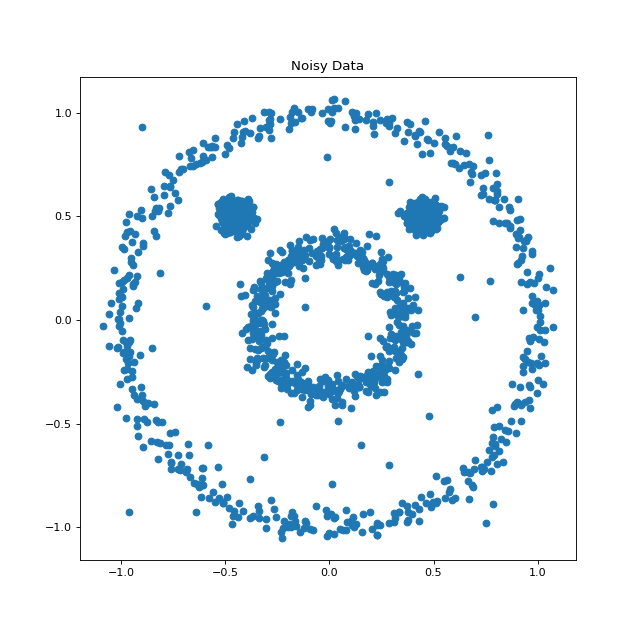

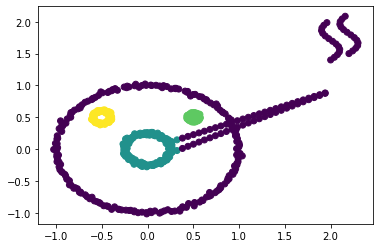

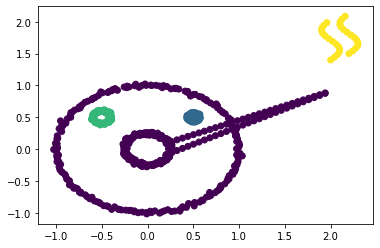

In [38]:
clusters = DBscan(eps=0.07, min_samples=14).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=clusters)
plt.show()

clusters = DBscan(eps=0.16, min_samples=4).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=clusters)
plt.show()


> Получите ещё 1 балл, если время работы вашего алгоритма больше референсного не более чем в 100 раз с учётом погрешности 3% от вашего времени:



In [39]:
%%time
%%capture
clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)

CPU times: total: 15.6 ms
Wall time: 9 ms


In [40]:
%%time
%%capture
clusters = DBscan(eps=0.2, min_samples=10).fit_predict(X)

CPU times: total: 2.58 s
Wall time: 2.78 s


## Применяем DBSCAN (3 балла)

__[1.5 балла]__ Возьмите колонки `Distance` и `DepTime` (из датасета о задержках самолётов). Запустите на тренировочной выборке на них DBSCAN. Нарисуйте облоко рассеивания с получившимися кластерами. Насколько много их вышло? 

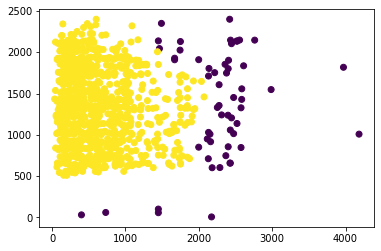

[-1  1]


In [41]:
np.random.seed(323)

# Берем 1000, иначе очень долго.
X = train[['Distance', 'DepTime']].sample(frac=0.01).values

clusters = DBscan(eps=250, min_samples=15).fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c=clusters)
plt.show()

# Ответ слишком уж от параметров зависит.
# Вот тут вышел один кластер, а второй полностью - выбросы. Выбросов много.
# Можно сказать, весьма логично.
print(np.unique(clusters))

100 5
[-1  1  2  3  4  5  6]


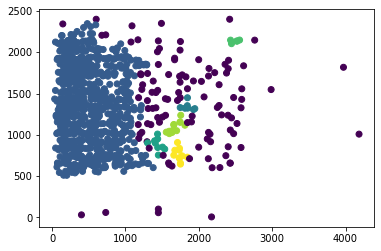

100 16
[-1  1  2  3  4  5]


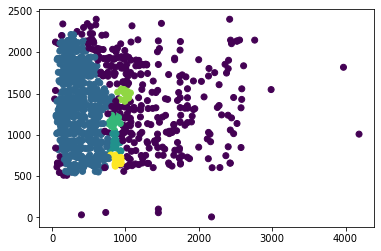

100 27
[-1  1  2  3]


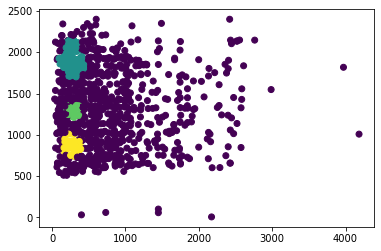

150 5
[-1  1  2  3]


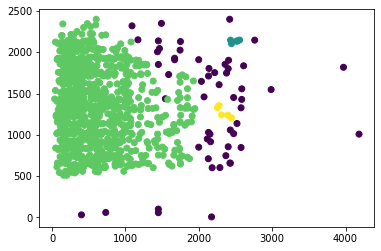

150 16
[-1  1]


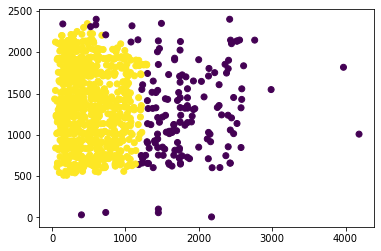

150 27
[-1  1  2]


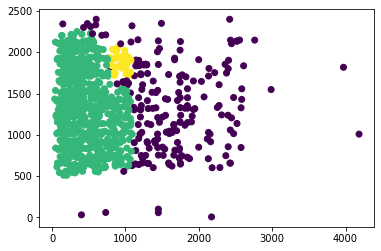

200 5
[-1  1  2  3  4  5]


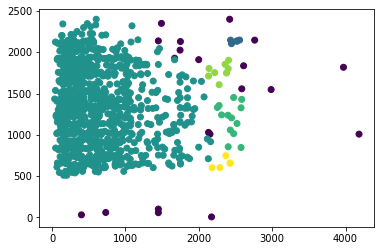

200 16
[-1  1  2]


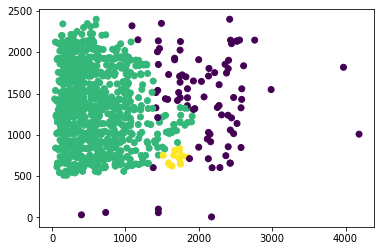

200 27
[-1  1]


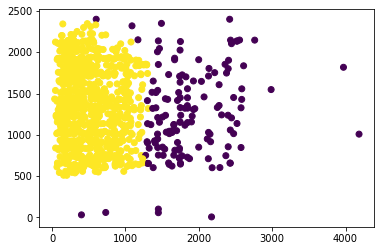

250 5
[-1  1]


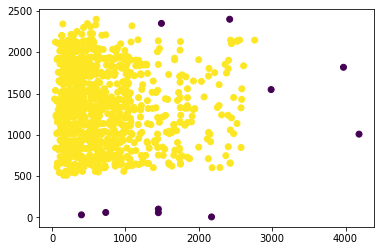

250 16
[-1  1]


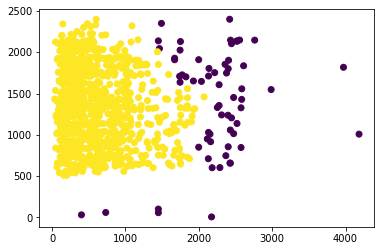

250 27
[-1  1  2]


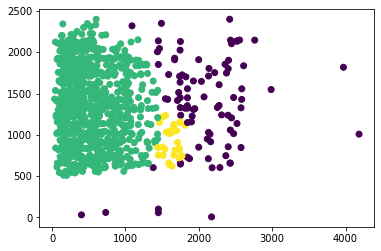

300 5
[-1  1]


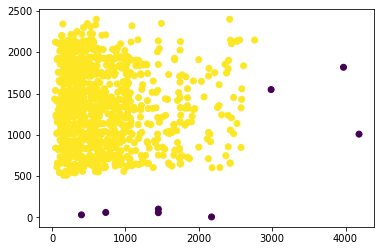

300 16
[-1  1]


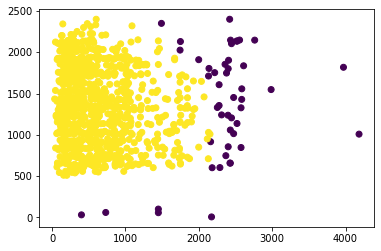

300 27
[-1  1]


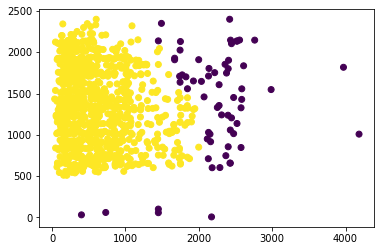

In [42]:
epss = range(100, 350, 50)
minns = range(5, 35, 11)

np.random.seed(342)

for e, m in itertools.product(epss, minns):
    print(e, m)
    clusters = DBscan(eps=e, min_samples=m).fit_predict(X)
    print(np.unique(clusters))
    plt.scatter(X[:, 0], X[:, 1], c=clusters)
    plt.show()

# При eps = 100, min_samples = 27 почти все - шум.
# Это происходит из-за слишком большого min_samples и небольшого расстояния.
# А вообще, кластеризация не такая уж и плохая, если считать шум отдельным кластером))
# Напрмер при eps = 200, min_samples = 27

__[1.5 балла]__ Добавьте в датасет новую категориальную переменную: номер кластера из DBSCAN и обучите Catboost со своими лучшими гиперпараметрами. Улучшилось ли качество модели на тестовой выборке? Как думаете, почему? 

In [117]:
train = pd.read_csv(
    'https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering-data/flight_delays_train.csv')
test = pd.read_csv(
    'https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering-data/flight_delays_test.csv')

X = train[['Distance', 'DepTime']].values
clusters = DBSCAN().fit_predict(X)
train['cluster'] = clusters

y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0})
X_train = train.drop('dep_delayed_15min', axis=1)
X_test = test

X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=43)

In [118]:
numeric_features = train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = train.select_dtypes(include=['object']).drop(['dep_delayed_15min'], axis=1).columns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

np.random.seed(43)

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [119]:
from catboost import CatBoostClassifier

np.random.seed(43)

clf = CatBoostClassifier(max_depth=10, n_estimators=900, logging_level='Silent')
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('classifier', clf)])
pipe.fit(X_train_part, y_train_part)
print('AUC ROC:', roc_auc_score(y_valid, pipe.predict_proba(X_valid)[:, 1]))

AUC ROC: 0.7568315006797437


In [120]:
X_train_part.drop('cluster', axis=1, inplace=True)

In [121]:
numeric_features = train.select_dtypes(include=['int64', 'float64']).drop(['cluster'], axis=1).columns
categorical_features = train.select_dtypes(include=['object']).drop(['dep_delayed_15min'], axis=1).columns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

np.random.seed(43)

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

from catboost import CatBoostClassifier

np.random.seed(43)
clf = CatBoostClassifier(max_depth=10, n_estimators=900, logging_level='Silent')
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('classifier', clf)])

In [122]:
np.random.seed(43)

pipe.fit(X_train_part, y_train_part)
print('AUC ROC:', roc_auc_score(y_valid, pipe.predict_proba(X_valid)[:, 1]))

# Качество с кластером чуть-чуть лучше. Возможно, есть какая-то связь, абсолютно ничтожная,
# которую смог найти бустинг. А может просто так случилось. В общем, видимый эффект не наблюдается.

AUC ROC: 0.7532386794587436


# Небольшие подарочки

**+0.1 балла** за фотографию того, как вы проводите лето на открытом воздухе

In [126]:
![](tech.jpg)

# Смотри архив!!

"[]" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


**+0.1 балла** за смешной мем по машинному обучению

In [129]:
![](meme.jpg)

# Смотри архив!!

"[]" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


**+0.1 балла** за развернутый отзыв о курсе: ваших впечатлениях, сложностях и радостях, любимых темах и т.д.

По мне так курс мегахорош. Из всех предметов второго семестра только иад доставлял удовольствие.
Из плюсов (возомжно):
- Простой язык объяснения
- В меру сложные дз
- Много контента. Кажется теперь можно сказать что основы ML так или иначе я знаю.
- После данного курса хочется делать карьеру в DS =)

Из минусов:
- Порой сильный рассинхрон лекций и семинаров
- Долгая проверка (дз, кр). Нельзя в следующем дз исправить косяки предыдущего.